after init:    c = [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
--------------------------------------------------------------
rule 1 / step 0)
--------------------------------------------------------------
   k0: 0 , g: [0 1 2 3] , eta: 0.5
   K0: [    1    3    5    7    9;     5    6    7    8    9]
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   W0: [    0    0    1    1    0;     0    1    0    0    1]
   b0: 0 , v0: [0 0 0 0]
   s0: [0 0] (||E||=0, theta:2)
   u0: 0 , y0: 0 , x0: 1
--------------------------------------------------------------
rule 1 / step 1a)
--------------------------------------------------------------
   u0: 0 , y0: 0 , x0: 1
--------------------------------------------------------------
rule 1 / step 1b)
--------------------------------------------------------------
   u0: 1 , y0: 1 , x0: 1


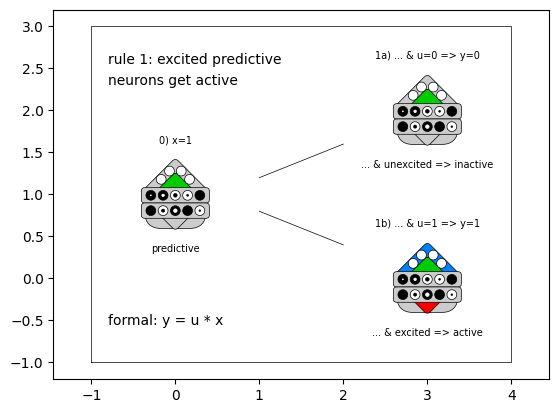

In [1]:
# === rule 1: excited predictive cells get active ===  

from carabao.neuron import Cell,toy
from carabao.screen import Monitor

mon = Monitor(m=3,n=4)
mon.text(-0.8,2.6,'rule 1: excited predictive',ha='left')
mon.text(-0.8,2.35,'neurons get active',ha='left')

k,g,K,P,c = toy('cell'); 
print("after init:    c =",c)

    # 0) create a cell and initialize it as predictive

cell = Cell(mon,k,g,K,P).set(x=1)
cell.plot(1,0,head='0) x=1',foot='predictive')
cell.log("rule 1 / step 0)")

   # 1a) apply rule 1 to an unexcited predictive cell

cell.set(x=1);  c = cell.rule1(u=0,c=[])
cell.plot(0,3,head='1a) ... & u=0 => y=0',foot='... & unexcited => inactive')
cell.log("rule 1 / step 1a)")

   # 1b) apply rule 1 to an excited predictive cell

cell.set(x=1);  c = cell.rule1(u=1,c=[])
cell.plot(2,3,head='1b) ... & u=1 => y=1',foot='... & excited => active')
cell.log("rule 1 / step 1b)")

    # draw lines

mon.line([1,2],[1+0.2,1+0.6]);
mon.line([1,2],[1-0.2,1-0.6]);

    # footer

mon.text(-0.8,-0.5,'formal: y = u * x',ha='left')


--------------------------------------------------------------
rule 2 / step 1a)
--------------------------------------------------------------
   k0: 0 , g: [0 1 2 3] , eta: 0.5
   K0: [    1    3    5    7    9;     5    6    7    8    9]
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   W0: [    0    0    1    1    0;     0    1    0    0    1]
   b0: 0 , v0: [0 0 0 0]
   s0: [0 0] (||E||=0, theta:2)
   u0: 0 , y0: 0 , x0: 0
   c: [0, 0, 0, 0]
--------------------------------------------------------------
rule 2 / step 2a)
--------------------------------------------------------------
   u0: 0 , y0: 0 , x0: 0
   c: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------------------------------
rule 2 / step 2a)
--------------------------------------------------------------
   b0: 1 , v0: [0 0 0 0]
   u0: 1 , y0: 0 , x0: 0
--------------------------------------------------------------
rule 2 / step 1b)
-----------------------------------------------------

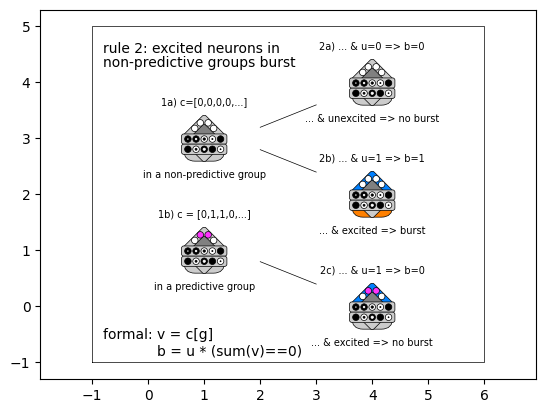

In [2]:
# === rule 2: excited neurons in non-predictive groups burst

from carabao.neuron import Cell,toy
from carabao.screen import Monitor

mon = Monitor(m=5,n=6)
mon.text(-0.8,4.6,'rule 2: excited neurons in',ha='left')
mon.text(-0.8,4.35,'non-predictive groups burst',ha='left')

k,g,K,P,c = toy('cell'); c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # 1a) create a cell in a non-predictive group

cell = Cell(mon,k,g,K,P).set(c=[0,0,0,0])
cell.plot(1,1,head='1a) c=[0,0,0,0,...]',foot='in a non-predictive group')
cell.log("rule 2 / step 1a)")

    # 2a) apply rule 2 to an unexcited cell in a non-predictive group

cell.set(); cell.rule2(u=0,c=c)
cell.plot(0,4,head='2a) ... & u=0 => b=0',foot='... & unexcited => no burst')
mon.line([2,3],[3+0.2,3+0.6]);
cell.log("rule 2 / step 2a)")

    # 3b) apply rule 2 to an excited cell in a non-predictive group

cell.set();  cell.rule2(u=1,c=c)
cell.plot(2,4,head='2b) ... & u=1 => b=1',foot='... & excited => burst')
mon.line([2,3],[3-0.2,3-0.6]);
cell.log("rule 2 / step 2a)")
         
    # 1b) create a cell in a predicting group

c = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
cell = Cell(mon,k,g,K,P).set(u=0,c=c)
cell.plot(3,1,head='1b) c = [0,1,1,0,...]',foot='in a predictive group')
cell.log("rule 2 / step 1b)")

    # 2c) apply rule 2 to an excited cell in a predictive group

cell.set(c);  c = cell.rule2(u=1,c=c)
cell.plot(4,4,head='2c) ... & u=1 => b=0',foot='... & excited => no burst')
mon.line([2,3],[1-0.2,1-0.6]);
cell.log("rule 2 / step 2c)")

    # footer

mon.text(-0.8,-0.5,'formal: v = c[g]',ha='left')
mon.text(0.16,-0.79,'b = u * (sum(v)==0)',ha='left')

after init:    c = [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
--------------------------------------------------------------
rule 3 / step 2)
--------------------------------------------------------------
   k0: 0 , g: [0 1 2 3] , eta: 0.5
   K0: [    1    3    5    7    9;     5    6    7    8    9]
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   W0: [    0    0    1    1    0;     0    1    0    0    1]
   b0: 1 , v0: [0 0 0 0]
   s0: [0 0] (||E||=0, theta:2)
   u0: 0 , y0: 0 , x0: 0
--------------------------------------------------------------
rule 3 / step 3a)
--------------------------------------------------------------
   u0: 0 , y0: 0 , x0: 1
--------------------------------------------------------------
rule 3 / step 3b)
--------------------------------------------------------------
   u0: 1 , y0: 1 , x0: 1


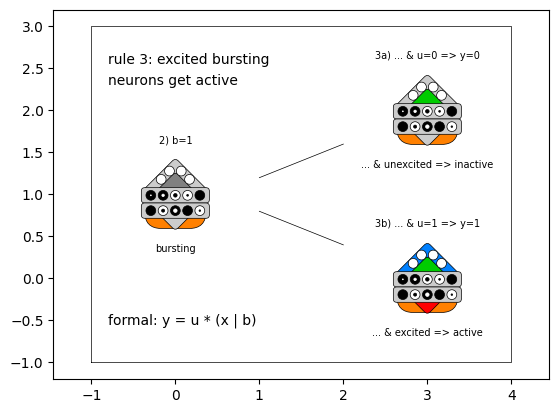

In [3]:
# === rule 3: excited bursting neurons get active ===

from carabao.neuron import Cell,toy
from carabao.screen import Monitor

mon = Monitor(m=3,n=4)
mon.text(-0.8,2.6,'rule 3: excited bursting',ha='left')
mon.text(-0.8,2.35,'neurons get active',ha='left')

k,g,K,P,c = toy('cell'); 
print("after init:    c =",c)

    # 2) create a bursting cell

cell = Cell(mon,k,g,K,P).set(b=1)
cell.plot(1,0,head='2) b=1',foot='bursting')
cell.log("rule 3 / step 2)")

   # 3a) apply rule 3 to an unexcited bursting cell

cell.set(x=1);  cell.rule3(u=0,c=[])
cell.plot(0,3,head='3a) ... & u=0 => y=0',foot='... & unexcited => inactive')
cell.log("rule 3 / step 3a)")

   # 3b) apply rule 3 to an excited bursting cell

cell.set(x=1);  cell.rule1(u=1,c=[]);  cell.set(c=[])
cell.plot(2,3,head='3b) ... & u=1 => y=1',foot='... & excited => active')
cell.log("rule 3 / step 3b)")

    # draw lines

mon.line([1,2],[1+0.2,1+0.6]);
mon.line([1,2],[1-0.2,1-0.6]);

    # footer

mon.text(-0.8,-0.5,'formal: y = u * (x | b)',ha='left')


after init:    c = [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
--------------------------------------------------------------
rule 4 / step 3)
--------------------------------------------------------------
   k0: 0 , g: [0 1 2 3] , eta: 0.5
   K0: [    1    3    5    7    9;     5    6    7    8    9]
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   W0: [    0    0    1    1    0;     0    1    0    0    1]
   b0: 0 , v0: [0 0 0 0]
   s0: [0 0] (||E||=0, theta:2)
   u0: 0 , y0: 0 , x0: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
--------------------------------------------------------------
rule 4 / step 4a)
--------------------------------------------------------------
   V0: [    0    0    1    1    0;     1    1    1    1    0]
   E0: [    0    0    1    1    0;     0    1    0    0    0]
   S0: [    1    1    1    1    1;     0    0    0    0    0]
   s0: [1 0] (||E||=2, theta:2)
   u0: 0 , y0: 0 , x0: 0
--------------------------------------------------------------
rule 4 / step 4b)

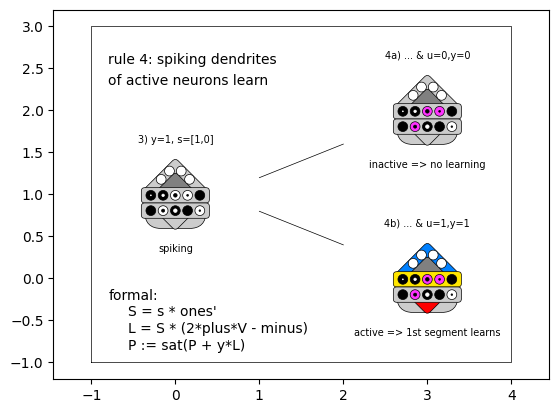

In [11]:
# === rule 4: spiking dentrites of activated cells learn

from carabao.neuron import Cell,toy
from carabao.screen import Monitor

mon = Monitor(m=3,n=4)
mon.text(-0.8,2.6,'rule 4: spiking dendrites',ha='left')
mon.text(-0.8,2.35,'of active neurons learn',ha='left')

k,g,K,P,c = toy('cell'); 
print("after init:    c =",c)

    # 3) create a cell and initialize as activated and spiking

cell = Cell(mon,k,g,K,P).set(c=c)
cell.plot(1,0,head='3) y=1, s=[1,0]',foot='spiking')
cell.log("rule 4 / step 3)")

   # 4a) apply rule 4 to an unexcited predictive cell

cell.rule4(u=0,c=c);
cell.plot(0,3,head='4a) ... & u=0,y=0',foot='inactive => no learning')
cell.log("rule 4 / step 4a)")

   # 4b) apply rule 4 to an excited predictive cell

cell.set(y=1);  cell.rule4(u=1,c=c);  
cell.plot(2,3,head='4b) ... & u=1,y=1',foot='active => 1st segment learns')
cell.log("rule 4 / step 4b)")

    # transition lines

mon.line([1,2],[1+0.2,1+0.6]);
mon.line([1,2],[1-0.2,1-0.6]);

    # footer

mon.text(-0.8, -.2,"formal:",ha='left')
mon.text(-.4-0.16, -.4,"S = s * ones'",ha='left')
mon.text(-.4-0.16,-.6,"L = S * (2*plus*V - minus)",ha='left')
mon.text(-.4-0.16,-.8,"P := sat(P + y*L)",ha='left')

--------------------------------------------------------------
rule 5 / step 4)
--------------------------------------------------------------
   k0: 0 , g: [0 1 2 3] , eta: 0.5
   K0: [    1    3    5    7    9;     5    6    7    8    9]
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   W0: [    0    0    1    1    0;     0    1    0    0    1]
   b0: 0 , v0: [0 0 0 0]
   s0: [0 0] (||E||=0, theta:2)
   u0: 1 , y0: 0 , x0: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
--------------------------------------------------------------
rule 5 / step 5a)
--------------------------------------------------------------
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   u0: 0 , y0: 0 , x0: 0
--------------------------------------------------------------
rule 4 / step 4b)
--------------------------------------------------------------
   u0: 1 , y0: 0 , x0: 0


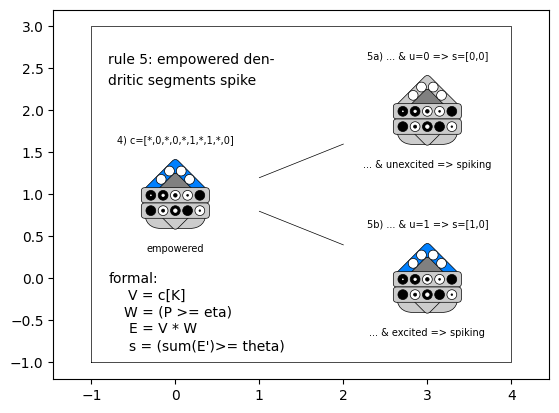

In [15]:
# === rule 5: empowered dendritic spike ===

from carabao.neuron import Cell,toy
from carabao.screen import Monitor

mon = Monitor(m=3,n=4)
mon.text(-0.8,2.6,'rule 5: empowered den-',ha='left')
mon.text(-0.8,2.35,'dritic segments spike',ha='left')

k,g,K,P,c = toy('cell'); 
W = (P>=0.5)*1;  E = W;

    # 4) create a cell and initialize it as empowered

cell = Cell(mon,k,g,K,P);  cell.set(u=0,c=c);
cell.plot(1,0,head='4) c=[*,0,*,0,*,1,*,1,*,0]',foot='empowered')
cell.log("rule 5 / step 4)")

    # 5a) apply rule 5 to an unexcited predictive cell

c = cell.rule5(u=0,c=c)
cell.plot(0,3,head='5a) ... & u=0 => s=[0,0]',foot='... & unexcited => spiking')
cell.log("rule 5 / step 5a)")

    # 5b) apply rule 5 to an excited predictive cell

c = cell.rule5(u=1,c=c)
cell.plot(2,3,head='5b) ... & u=1 => s=[1,0]',foot='... & excited => spiking')
cell.log("rule 4 / step 4b)")

    # transition lines

mon.line([1,2],[1+0.2,1+0.6]);
mon.line([1,2],[1-0.2,1-0.6]);

    # footer

mon.text(-0.8, 0,"formal:",ha='left')
mon.text(-.4-0.16, -.2,"V = c[K]",ha='left')
mon.text(-.4-0.21,-.4,"W = (P >= eta)",ha='left')
mon.text(-.4-0.15,-.6,"E = V * W",ha='left')
mon.text(-.4-0.15,-.8,"s = (sum(E')>= theta)",ha='left')

--------------------------------------------------------------
rule 6 / step 5)
--------------------------------------------------------------
   k0: 0 , g: [0 1 2 3] , eta: 0.5
   K0: [    1    3    5    7    9;     5    6    7    8    9]
   P0: [  .12  .32  .54  .77    0;     0  .61  .45    0  0.8]
   W0: [    0    0    1    1    0;     0    1    0    0    1]
   b0: 0 , v0: [0 0 0 0]
   s0: [0 0] (||E||=0, theta:2)
   u0: 0 , y0: 0 , x0: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
--------------------------------------------------------------
rule 6 / step 6a)
--------------------------------------------------------------
   u0: 0 , y0: 0 , x0: 0
--------------------------------------------------------------
rule 6 / step 6b)
--------------------------------------------------------------
   u0: 1 , y0: 0 , x0: 0


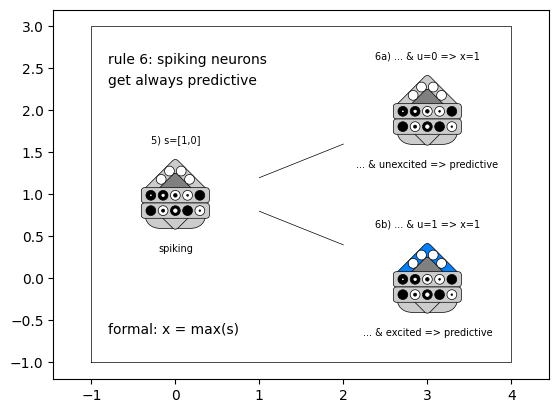

In [6]:
# === rule 6: spiking neurons get always predictive ===

from carabao.neuron import Cell,toy
from carabao.screen import Monitor

mon = Monitor(m=3,n=4)
mon.text(-0.8,2.6,'rule 6: spiking neurons',ha='left')

k,g,K,P,c = toy('cell'); 

    # 5) create a cell and initialize it as spiking

cell = Cell(mon,k,g,K,P).set(c=c)
cell.plot(1,0,head='5) s=[1,0]',foot='spiking')
cell.log("rule 6 / step 5)")

   # 6a) apply rule 1 to an unexcited spiking cell

c = cell.rule6(u=0,c=c);
cell.plot(0,3,head='6a) ... & u=0 => x=1',foot='... & unexcited => predictive')
cell.log("rule 6 / step 6a)")

   # 6b) apply rule 1 to an excited spiking cell

c = cell.rule6(u=1,c=c)
cell.plot(2,3,head='6b) ... & u=1 => x=1',foot='... & excited => predictive')
cell.log("rule 6 / step 6b)")

    # draw lines

mon.line([1,2],[1+0.2,1+0.6]);
mon.line([1,2],[1-0.2,1-0.6]);

    # footer

mon.text(-0.8,2.35,'get always predictive',ha='left')
mon.text(-0.8,-0.6,'formal: x = max(s)',ha='left')